In [1]:
# ===== Import Libraries =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ===== Load Data =====
df = pd.read_csv("https://docs.google.com/spreadsheets/d/10oq0gqZKdI-wg0PSQmVnBWf8fhc6qH4DG91YTKehH-A/export?format=csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(['Junction', 'DateTime'])
print(f"Data load: {df.shape}")
df.head()

Data load: (48120, 16)


,DateTime,Junction,Vehicles,ID,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,Date,event_name,event_type,city,sports_event,concert,public_holiday,public_demonstration
0,2015-11-01 00:00:00,1,15,20151101001,0.366609,0.715399,0.0,0.144331,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
1,2015-11-01 01:00:00,1,13,20151101011,0.342513,0.761021,0.0,0.156549,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
2,2015-11-01 02:00:00,1,10,20151101021,0.314974,0.803642,0.0,0.143348,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
3,2015-11-01 03:00:00,1,7,20151101031,0.301205,0.820109,0.0,0.151966,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration
4,2015-11-01 04:00:00,1,9,20151101041,0.292599,0.825532,0.0,0.190746,2015-11-01,No Event,NaN,NaN,No Sport,No concert,No holding,No demonstration


In [3]:
# ===== Feature Engineering =====
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsRushHour'] = (((df['Hour'] >= 7) & (df['Hour'] <= 10)) | ((df['Hour'] >= 17) & (df['Hour'] <= 20))).astype(int)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

In [4]:
# Lag features
for j in df['Junction'].unique():
    mask = df['Junction'] == j
    for lag in [1, 2, 3, 6, 12, 24]:
        df.loc[mask, f'Lag_{lag}h'] = df.loc[mask, 'Vehicles'].shift(lag)
    df.loc[mask, 'Rolling_3h'] = df.loc[mask, 'Vehicles'].rolling(3, min_periods=1).mean()

df = df.dropna()
print(f"Features created: {df.shape}")

Features created: (3264, 30)


In [5]:
# ===== Define Features & Split Data =====
features = ['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'IsRushHour', 
            'Hour_sin', 'Hour_cos', 'Lag_1h', 'Lag_2h', 'Lag_3h', 
            'Lag_6h', 'Lag_12h', 'Lag_24h', 'Rolling_3h']
target = 'Vehicles'
junctions = sorted(df['Junction'].unique())

splits = {}
for j in junctions:
    jdf = df[df['Junction'] == j]
    split = int(len(jdf) * 0.8)
    splits[j] = {
        'X_train': jdf[features].iloc[:split],
        'y_train': jdf[target].iloc[:split],
        'X_test': jdf[features].iloc[split:],
        'y_test': jdf[target].iloc[split:]
    }
    print(f"Junction {j}: Train={split}, Test={len(jdf)-split}")

Junction 1: Train=768, Test=192
Junction 2: Train=768, Test=192
Junction 3: Train=768, Test=192
Junction 4: Train=307, Test=77


### Model Development and Training

In [6]:
# ===== MODEL 1 - ARIMA =====
print("\n=== ARIMA MODELS ===")
arima_results = {}
for j in junctions:
    try:
        model = ARIMA(splits[j]['y_train'], order=(2,1,2)).fit()
        pred = model.forecast(len(splits[j]['y_test']))
        mae = mean_absolute_error(splits[j]['y_test'], pred)
        r2 = r2_score(splits[j]['y_test'], pred)
        arima_results[j] = {'pred': pred.values, 'actual': splits[j]['y_test'].values, 'mae': mae, 'r2': r2}
        print(f"Junction {j}: MAE={mae:.2f}, R²={r2:.3f}")
    except:
        print(f"Junction {j}: Failed")


=== ARIMA MODELS ===
Junction 1: MAE=21.00, R²=-0.408
Junction 2: MAE=10.47, R²=-1.798
Junction 3: MAE=7.61, R²=-0.021
Junction 4: MAE=3.18, R²=-1.148


In [7]:
# ===== MODEL 2 - LSTM =====
print("\n=== LSTM MODELS ===")
lstm_results = {}
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()

for j in junctions:
    X_train_sc = scaler_X.fit_transform(splits[j]['X_train'])
    X_test_sc = scaler_X.transform(splits[j]['X_test'])
    y_train_sc = scaler_y.fit_transform(splits[j]['y_train'].values.reshape(-1,1))
    
    X_train_lstm = X_train_sc.reshape((X_train_sc.shape[0], 1, X_train_sc.shape[1]))
    X_test_lstm = X_test_sc.reshape((X_test_sc.shape[0], 1, X_test_sc.shape[1]))
    
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train_sc.shape[1])),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train_sc, epochs=30, batch_size=32, validation_split=0.2, verbose=0,
              callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])
    
    pred_sc = model.predict(X_test_lstm, verbose=0)
    pred = scaler_y.inverse_transform(pred_sc).flatten()
    mae = mean_absolute_error(splits[j]['y_test'], pred)
    r2 = r2_score(splits[j]['y_test'], pred)
    lstm_results[j] = {'pred': pred, 'actual': splits[j]['y_test'].values, 'mae': mae, 'r2': r2}
    print(f"Junction {j}: MAE={mae:.2f}, R²={r2:.3f}")


=== LSTM MODELS ===
Junction 1: MAE=7.21, R²=0.772
Junction 2: MAE=2.93, R²=0.733
Junction 3: MAE=3.04, R²=0.796
Junction 4: MAE=1.62, R²=0.444


In [8]:
# ===== MODEL 3 - XGBoost =====
print("\n=== XGBoost MODELS ===")
xgb_results = {}

for j in junctions:
    model = xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)
    model.fit(splits[j]['X_train'], splits[j]['y_train'])
    pred = model.predict(splits[j]['X_test'])
    mae = mean_absolute_error(splits[j]['y_test'], pred)
    rmse = np.sqrt(mean_squared_error(splits[j]['y_test'], pred))
    r2 = r2_score(splits[j]['y_test'], pred)
    mape = mean_absolute_percentage_error(splits[j]['y_test'], pred) * 100
    
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_}).sort_values('Importance', ascending=False)
    xgb_results[j] = {'model': model, 'pred': pred, 'actual': splits[j]['y_test'].values, 
                      'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape, 'feat_imp': feat_imp}
    print(f"Junction {j}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}, MAPE={mape:.1f}%")

# ===== CELL 9: Model Comparison Table =====
comp = []
for j in junctions:
    if j in arima_results:
        comp.append({'Junction': j, 'Model': 'ARIMA', 'MAE': arima_results[j]['mae'], 'R²': arima_results[j]['r2']})
    comp.append({'Junction': j, 'Model': 'LSTM', 'MAE': lstm_results[j]['mae'], 'R²': lstm_results[j]['r2']})
    comp.append({'Junction': j, 'Model': 'XGBoost', 'MAE': xgb_results[j]['mae'], 'R²': xgb_results[j]['r2']})

comp_df = pd.DataFrame(comp)
print("\n=== MODEL COMPARISON ===")
print(comp_df.to_string(index=False))


=== XGBoost MODELS ===
Junction 1: MAE=3.23, RMSE=5.34, R²=0.927, MAPE=5.2%
Junction 2: MAE=1.47, RMSE=2.12, R²=0.908, MAPE=7.0%
Junction 3: MAE=1.96, RMSE=3.35, R²=0.891, MAPE=9.9%
Junction 4: MAE=0.88, RMSE=1.25, R²=0.772, MAPE=14.3%

=== MODEL COMPARISON ===
 Junction   Model       MAE        R²
        1   ARIMA 21.001469 -0.407928
        1    LSTM  7.208588  0.772460
        1 XGBoost  3.230891  0.926920
        2   ARIMA 10.466258 -1.797792
        2    LSTM  2.929068  0.733492
        2 XGBoost  1.468192  0.908012
        3   ARIMA  7.605056 -0.021126
        3    LSTM  3.039023  0.796376
        3 XGBoost  1.959531  0.890539
        4   ARIMA  3.183309 -1.148359
        4    LSTM  1.616150  0.443651
        4 XGBoost  0.878947  0.771921


### Cross-Validation

In [9]:
# ===== Cross-Validation =====
print("\n=== CROSS-VALIDATION (XGBoost) ===")
cv_results = []

for j in junctions:
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    for train_idx, val_idx in tscv.split(splits[j]['X_train']):
        X_tr = splits[j]['X_train'].iloc[train_idx]
        y_tr = splits[j]['y_train'].iloc[train_idx]
        X_val = splits[j]['X_train'].iloc[val_idx]
        y_val = splits[j]['y_train'].iloc[val_idx]
        
        model = xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=42)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        scores.append(mean_absolute_error(y_val, pred))
    
    cv_results.append({
        'Junction': j,
        'Fold1': scores[0], 'Fold2': scores[1], 'Fold3': scores[2],
        'Fold4': scores[3], 'Fold5': scores[4],
        'Mean': np.mean(scores), 'Std': np.std(scores)
    })
    print(f"Junction {j}: CV MAE={np.mean(scores):.2f} (±{np.std(scores):.2f})")

cv_df = pd.DataFrame(cv_results)
print("\n", cv_df.to_string(index=False))


=== CROSS-VALIDATION (XGBoost) ===
Junction 1: CV MAE=4.20 (±1.46)
Junction 2: CV MAE=1.81 (±1.15)
Junction 3: CV MAE=2.24 (±0.77)
Junction 4: CV MAE=1.31 (±0.51)

  Junction    Fold1    Fold2    Fold3    Fold4    Fold5     Mean      Std
        1 6.915315 3.848290 2.598738 3.409123 4.207892 4.195872 1.461926
        2 2.117849 1.152673 0.974702 0.879216 3.944272 1.813742 1.152908
        3 1.941879 3.079883 0.963906 2.225107 2.992424 2.240640 0.773183
        4 2.245863 1.377678 1.219077 0.855725 0.846765 1.309022 0.511788


### Data Visualization

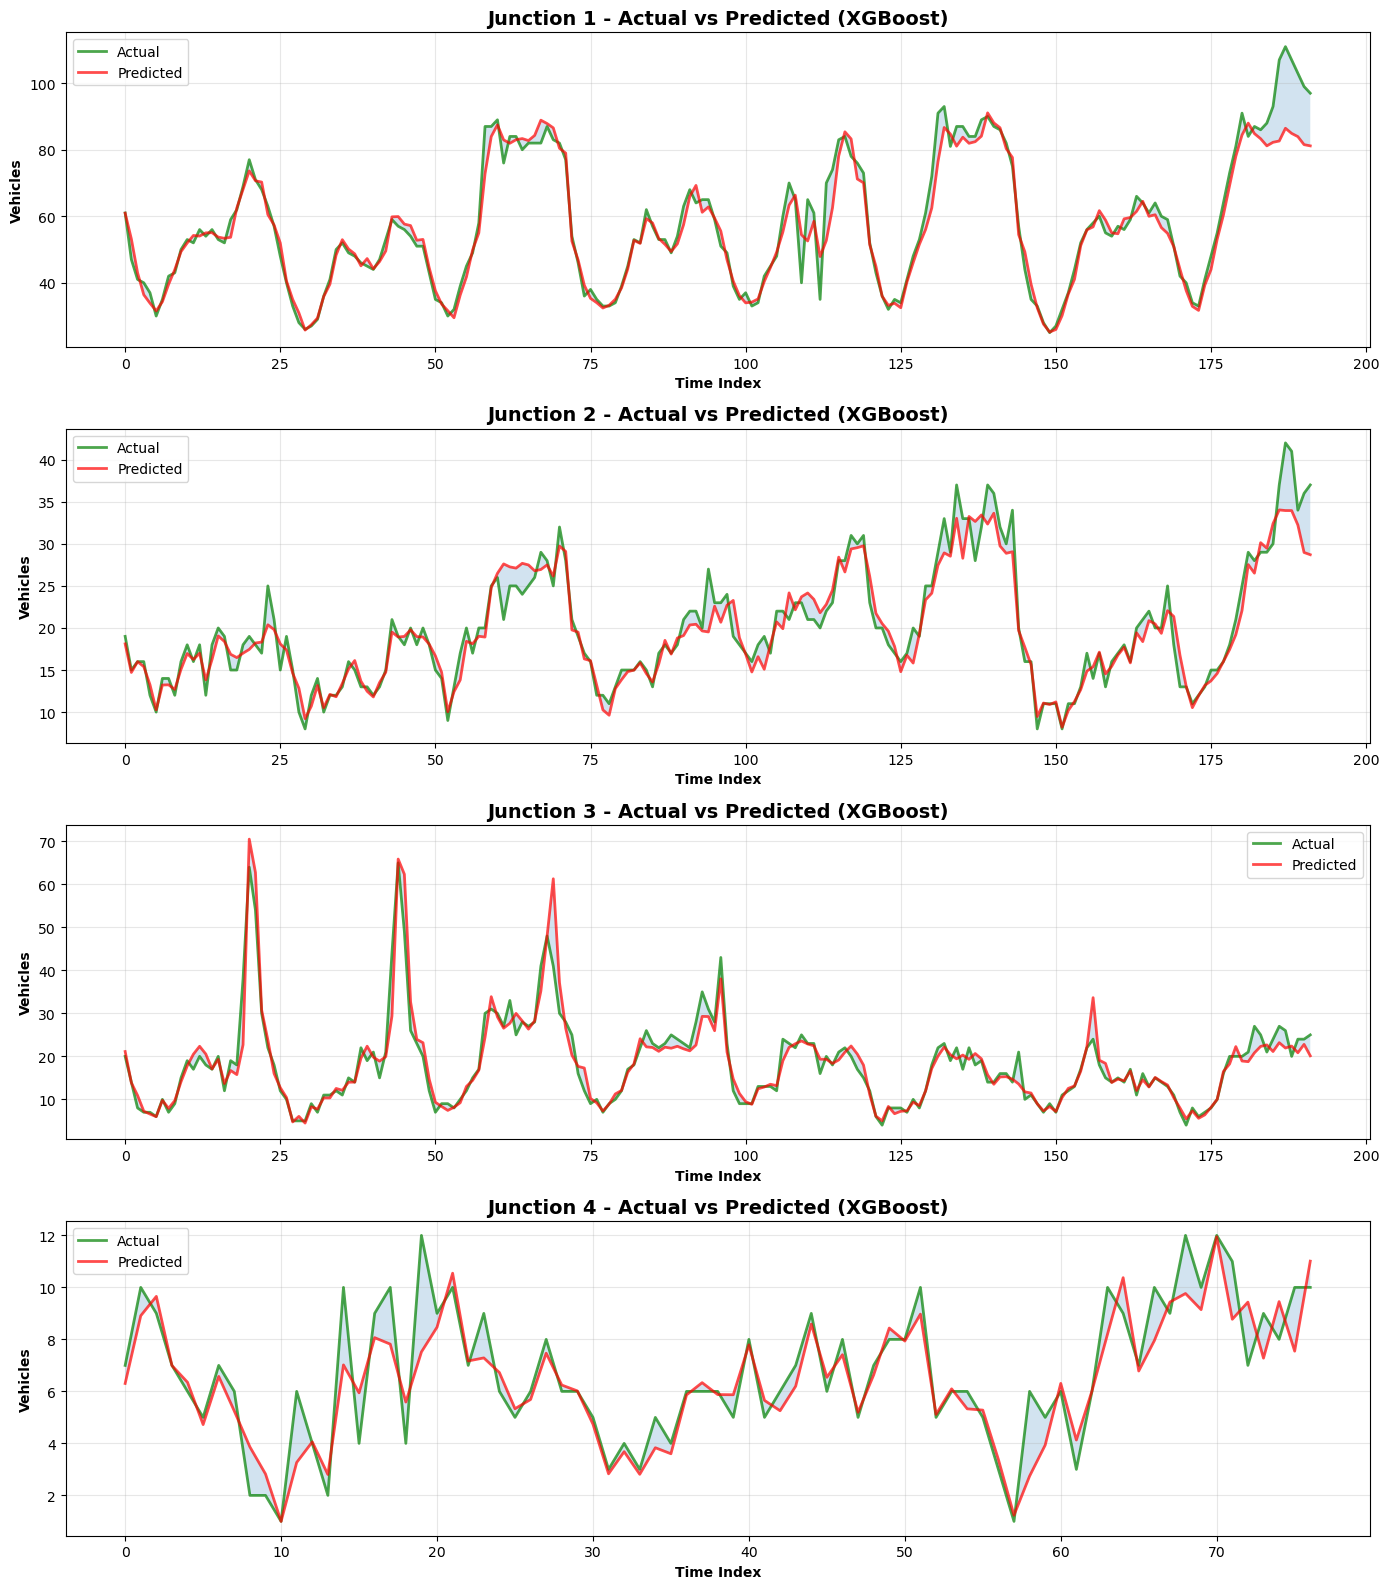

Saved: actual_vs_predicted.png


In [10]:
# ===== Visualization 1 - Actual vs Predicted =====
fig, axes = plt.subplots(len(junctions), 1, figsize=(14, 4*len(junctions)))
if len(junctions) == 1:
    axes = [axes]

for idx, j in enumerate(junctions):
    ax = axes[idx]
    actual = xgb_results[j]['actual']
    pred = xgb_results[j]['pred']
    x = range(len(actual))
    
    ax.plot(x, actual, label='Actual', linewidth=2, color='green', alpha=0.7)
    ax.plot(x, pred, label='Predicted', linewidth=2, color='red', alpha=0.7)
    ax.fill_between(x, actual, pred, alpha=0.2)
    ax.set_title(f'Junction {j} - Actual vs Predicted (XGBoost)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Time Index', fontweight='bold')
    ax.set_ylabel('Vehicles', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: actual_vs_predicted.png")

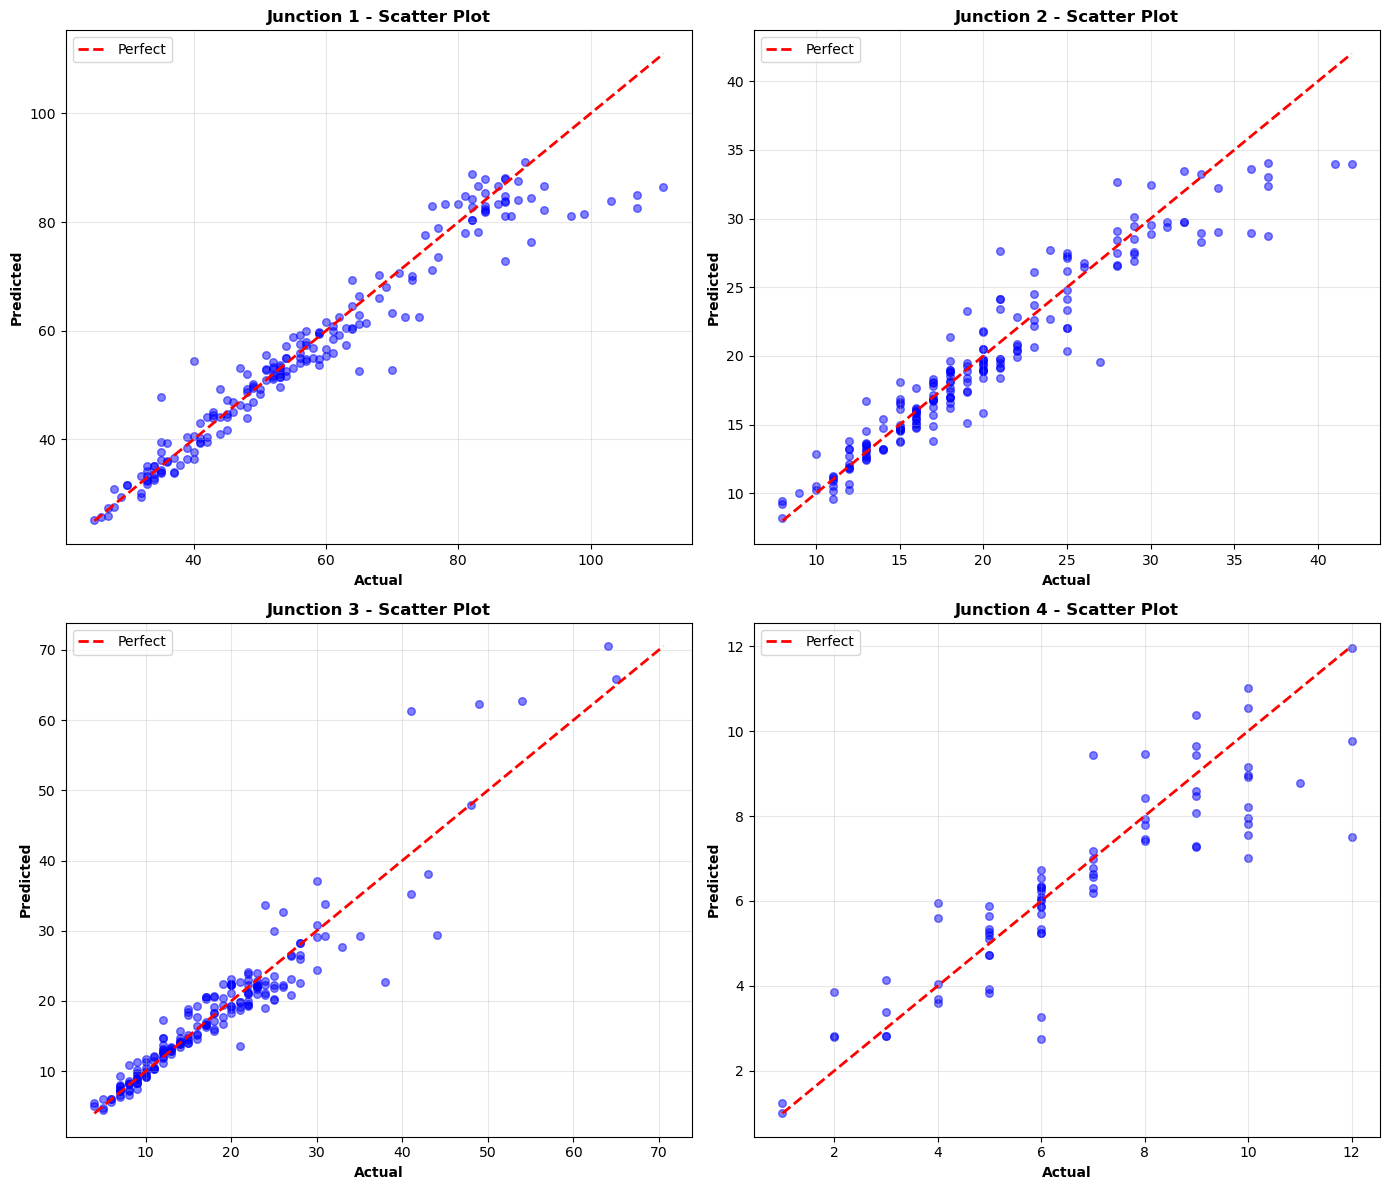

Saved: scatter_plots.png


In [11]:
# ===== Visualization 2 - Scatter Plots =====
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, j in enumerate(junctions):
    ax = axes[idx]
    actual = xgb_results[j]['actual']
    pred = xgb_results[j]['pred']
    
    ax.scatter(actual, pred, alpha=0.5, s=30, color='blue')
    lims = [min(actual.min(), pred.min()), max(actual.max(), pred.max())]
    ax.plot(lims, lims, 'r--', lw=2, label='Perfect')
    ax.set_title(f'Junction {j} - Scatter Plot', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual', fontweight='bold')
    ax.set_ylabel('Predicted', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: scatter_plots.png")

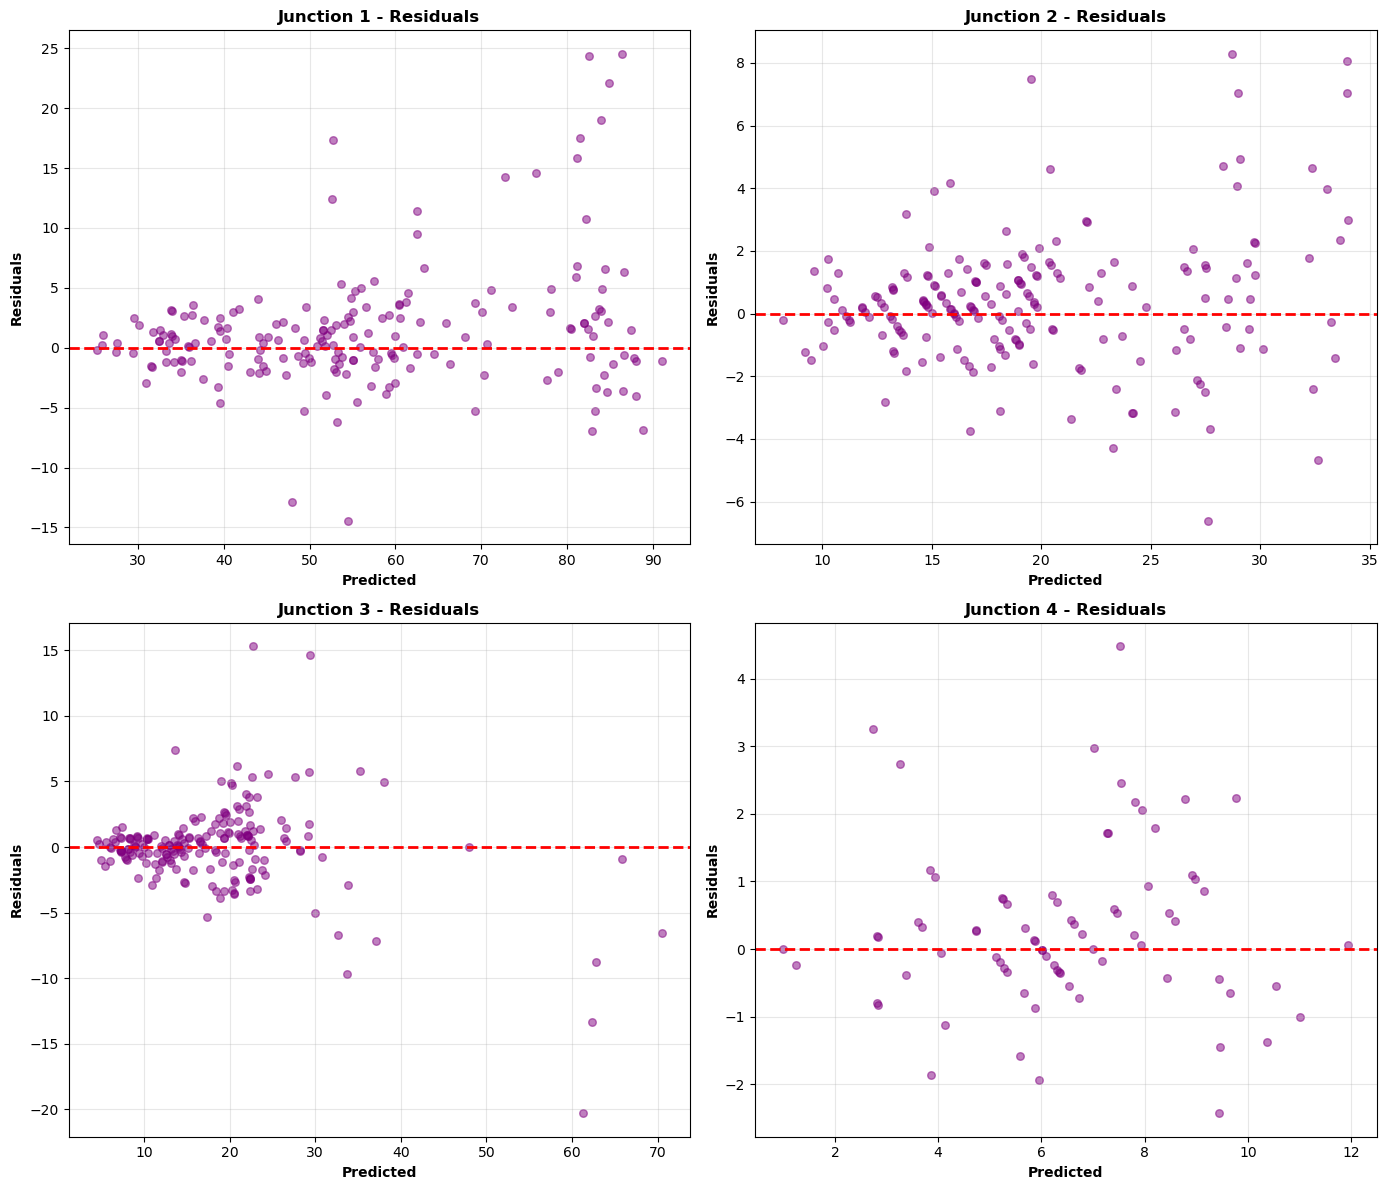

Saved: residual_plots.png


In [12]:
# ===== Visualization 3 - Residual Plots =====
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, j in enumerate(junctions):
    ax = axes[idx]
    actual = xgb_results[j]['actual']
    pred = xgb_results[j]['pred']
    residuals = actual - pred
    
    ax.scatter(pred, residuals, alpha=0.5, s=30, color='purple')
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_title(f'Junction {j} - Residuals', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('Residuals', fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: residual_plots.png")

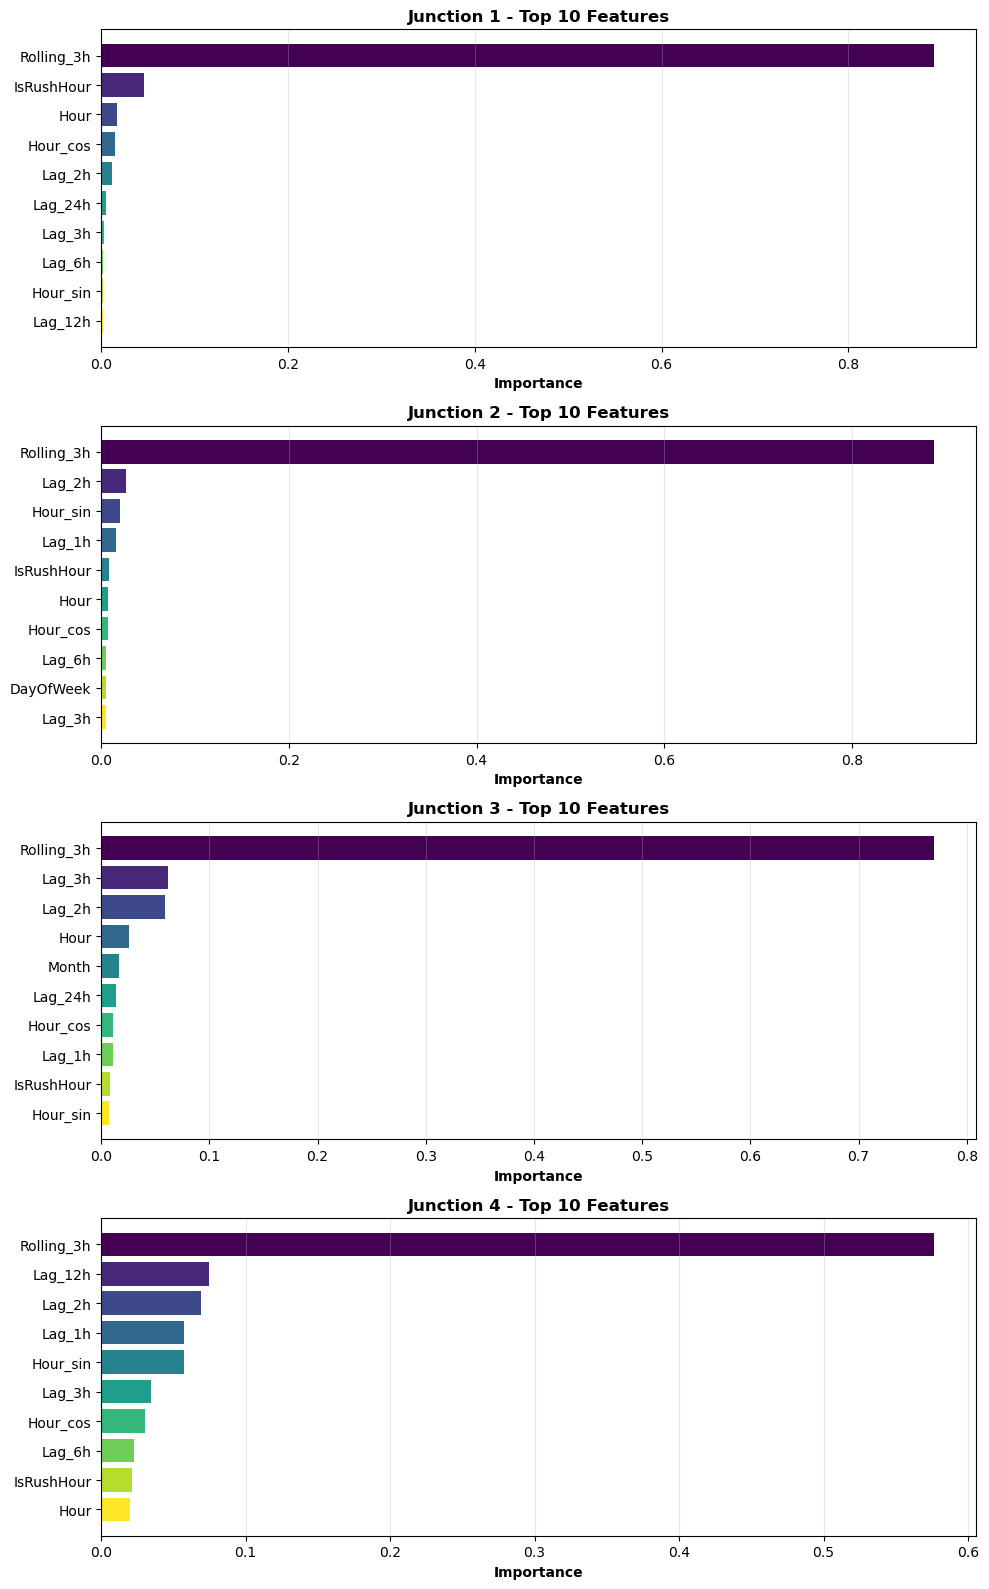

Saved: feature_importance.png


In [13]:
# ===== Feature Importance =====
fig, axes = plt.subplots(len(junctions), 1, figsize=(10, 4*len(junctions)))
if len(junctions) == 1:
    axes = [axes]

for idx, j in enumerate(junctions):
    ax = axes[idx]
    feat_imp = xgb_results[j]['feat_imp'].head(10)
    colors = plt.cm.viridis(np.linspace(0, 1, len(feat_imp)))
    ax.barh(range(len(feat_imp)), feat_imp['Importance'], color=colors)
    ax.set_yticks(range(len(feat_imp)))
    ax.set_yticklabels(feat_imp['Feature'])
    ax.set_title(f'Junction {j} - Top 10 Features', fontsize=12, fontweight='bold')
    ax.set_xlabel('Importance', fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: feature_importance.png")

In [14]:
# ===== Save Models =====

print("\n OUTPUTS GENERATED:")
print("1. Trained Models: ARIMA, LSTM, XGBoost")
print("2. Comparison Table (comp_df)")
print("3. Cross-Validation Results (cv_df)")
print("4. Visualizations: 4 PNG files")

print("\n BEST MODEL: XGBoost")
print(f" Average MAE: {comp_df[comp_df['Model']=='XGBoost']['MAE'].mean():.2f}")
print(f" Average R²: {comp_df[comp_df['Model']=='XGBoost']['R²'].mean():.3f}")


 OUTPUTS GENERATED:
1. Trained Models: ARIMA, LSTM, XGBoost
2. Comparison Table (comp_df)
3. Cross-Validation Results (cv_df)
4. Visualizations: 4 PNG files

 BEST MODEL: XGBoost
 Average MAE: 1.88
 Average R²: 0.874
